# Decision Tree Model

## Load Pacakage

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree
import plotly.express as px
from sklearn.model_selection import cross_val_score, cross_validate

## Load Data

In [2]:
## Read the Data
Clean_DF = pd.read_csv('Steam_Clean_Data.csv')
Train_reco = pd.read_csv('Train_reco.csv')
Test_reco = pd.read_csv('Test_reco.csv')

## Data Preparation

#### Use tfidvectorizer to transform text data

In [3]:
## Instantiate the TfidfVectorizer
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])

#### Convert tfidvectorizer result to pandas data frame

In [4]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## Recommendation Model

### Base Model

#### Instantiate the DT model

In [6]:
## Instantiate the Decision Tree Model and Fit the Data
MyDT_reco=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            #min_impurity_split=None, 
                            class_weight=None)

#### Fit the training data into the model

In [7]:
MyDT_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

feature_names = Train_DTM_DF_reco.columns
class_names = Train_reco['recommendation'].unique()

#### Visualize the Decision Tree

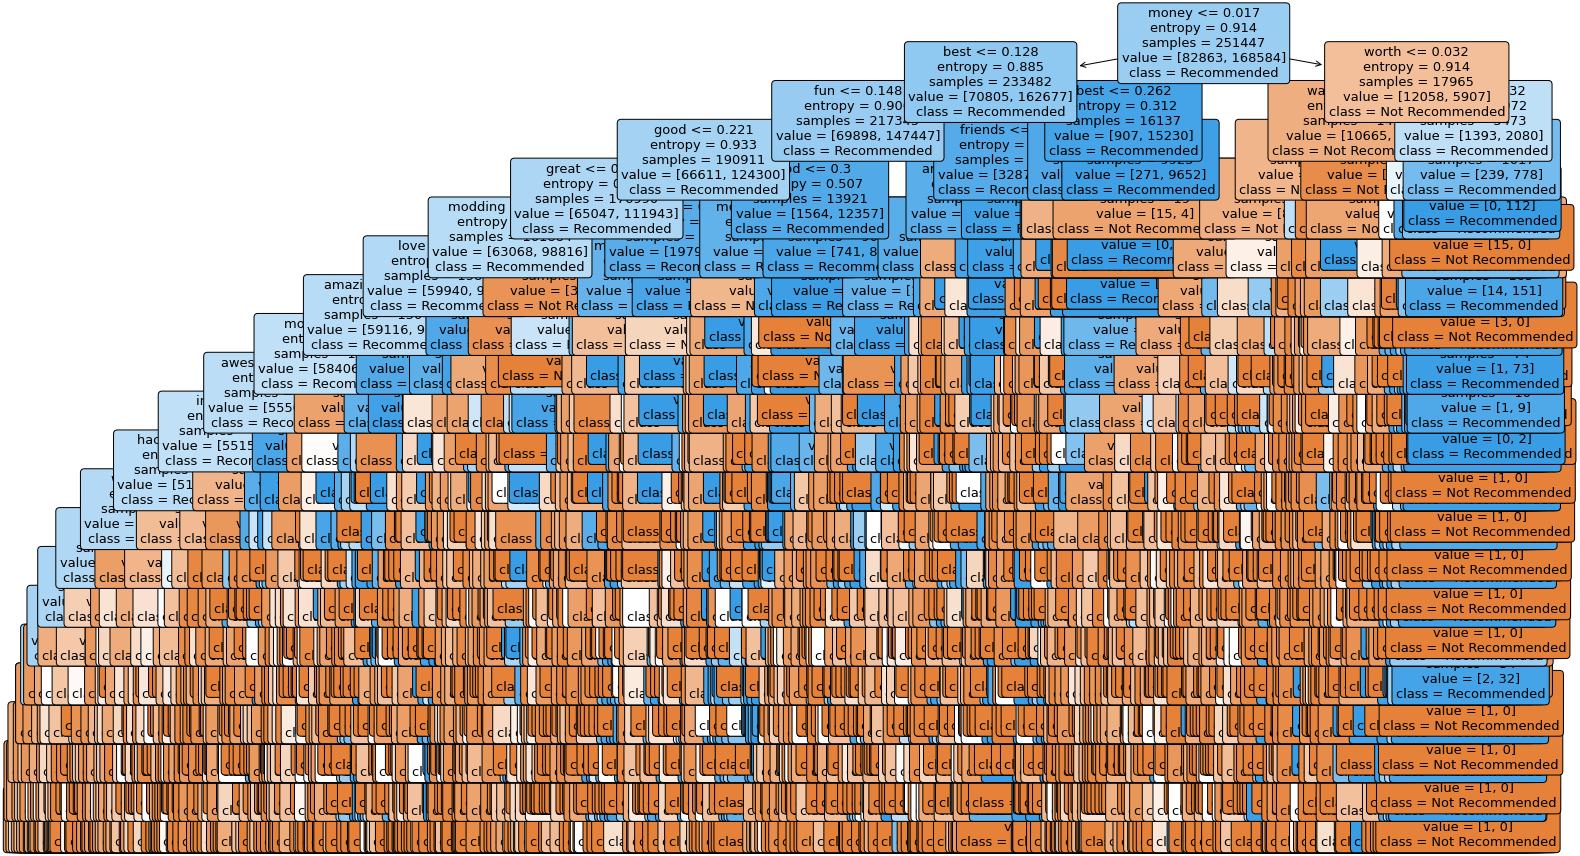

In [8]:
fig = plt.figure(figsize=(25, 15))
MyTree1 = tree.plot_tree(MyDT_reco, impurity=True, rounded=True,
                         feature_names = feature_names, 
                         class_names = class_names, 
                         filled=True, fontsize=13)
plt.savefig('DT.jpg')

#### Predict

In [9]:
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DT_pred_reco=MyDT_reco.predict(Test_DTM_DF_reco)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



#### Evaluate the model with confusion matrix and accuracy


The confusion matrix is:
[[11790 15831]
 [ 3962 52233]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



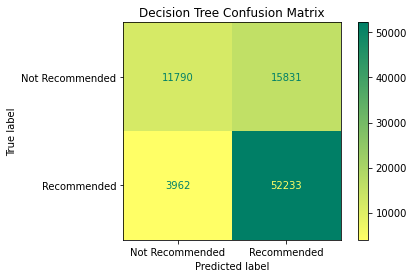


The accuracy of Decision Tree model is: 0.7638517705450033


In [10]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(MyDT_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
plt.title("Decision Tree Confusion Matrix")
plt.savefig('DT_CM.jpg')
plt.show()
print("\nThe accuracy of Decision Tree model is:",accuracy_score(Test_reco['recommendation'], DT_pred_reco))

### Cross Validation

#### Instantiate a New TfidfVectorizer

In [11]:
Tfidf=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",
    max_features = 1000)
Train_cv = Tfidf.fit_transform(Clean_DF["review"])
Train_cv_DF=pd.DataFrame(Train_cv.toarray(),columns=Tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



#### Transfer the label to (0,1)

In [12]:
Label = [1 if Clean_DF.iloc[i,1]=="Recommended" else 0 for i in range(len(Clean_DF))]

#### Use cross_validate to conduct a cross validation

In [13]:
output = cross_validate(estimator=MyDT_reco, X=Train_cv_DF, y=Label, 
                            cv=6, scoring=['accuracy','precision','f1'], return_estimator =True)

#### Evaluation of CV

In [14]:
print("The averege accuracy of cross validation is %.2f\n" % output['test_accuracy'].mean())
print("The averege precision of cross validation is %.2f\n" % output['test_precision'].mean())
print("The averege f1 of cross validation is %.2f\n" % output['test_f1'].mean())

The averege accuracy of cross validation is 0.75

The averege precision of cross validation is 0.76

The averege f1 of cross validation is 0.83



### Feature Importance of CV

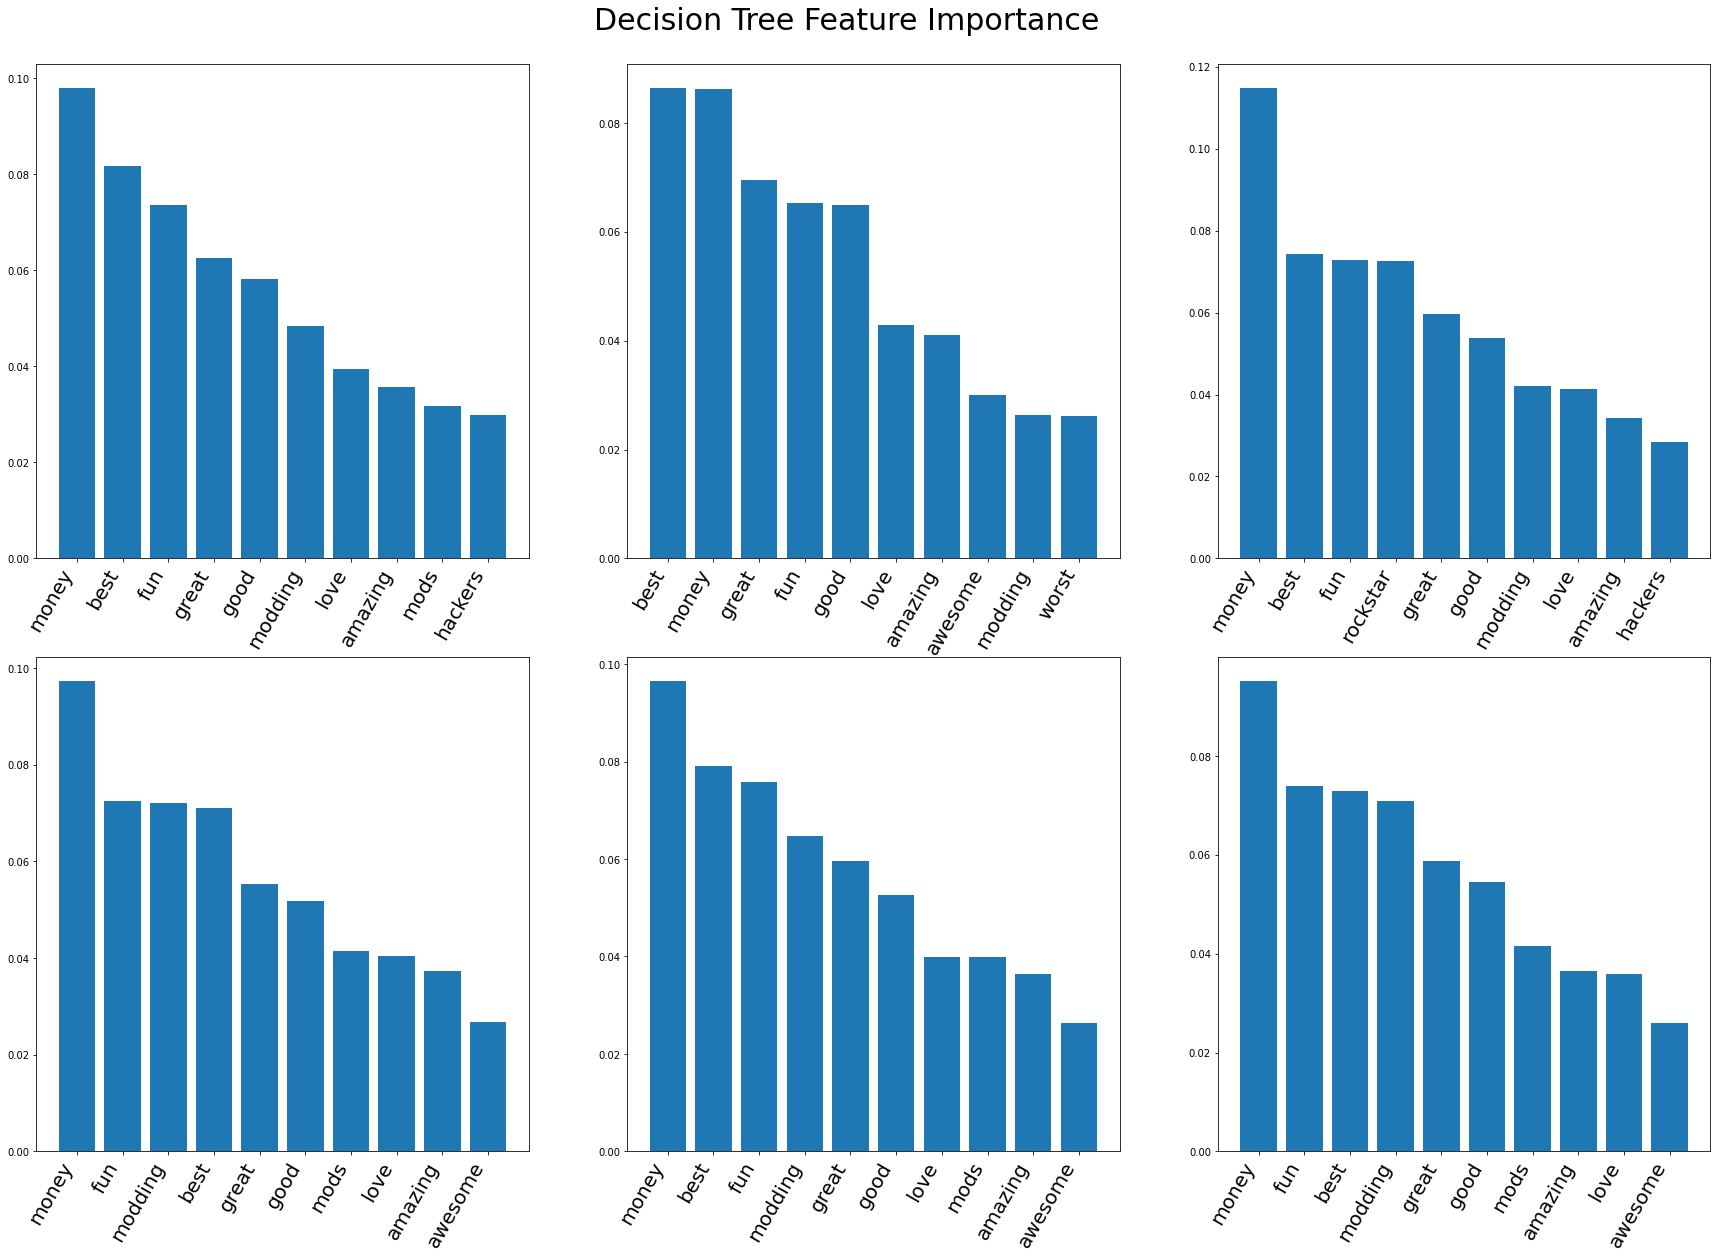

In [15]:
fig=plt.figure(figsize=(30,20))
plt.suptitle("Decision Tree Feature Importance", fontsize = 30, y = 0.92)
for idx,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = Train_cv_DF.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    #print(feature_importances[:10:])
    plt.subplot(231+idx)
    plt.bar(x = feature_importances.index[:10:], height=feature_importances["importance"][:10:])
    plt.xticks(rotation=60, ha='right', fontsize = 20)

plt.savefig("DT_Imp.jpg")